<a href="https://colab.research.google.com/github/magnetbrains-bit/end-to-end-ml-pipeline-retail/blob/main/Retailrocket_recommender_system_dataset_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from datetime import timedelta
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import json

# This will prompt you to upload your 'kaggle.json' API token.
# You only need to do this once per session.
if not pd.io.common.file_exists('kaggle.json'):
    files.upload()
else:
    print("kaggle.json already exists.")

# Configure the Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API configured.")


kaggle.json already exists.
Kaggle API configured.


In [ ]:
!kaggle datasets download -d retailrocket/ecommerce-dataset

# Unzip the downloaded file
!unzip -o ecommerce-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset
License(s): CC-BY-NC-SA-4.0
ecommerce-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ecommerce-dataset.zip
  inflating: category_tree.csv       
  inflating: events.csv              
  inflating: item_properties_part1.csv  
  inflating: item_properties_part2.csv  


In [ ]:
events_df = pd.read_csv('events.csv')
category_tree_df = pd.read_csv('category_tree.csv')

# The item properties are split into two files, so we load and concatenate them.
item_props_df_part1 = pd.read_csv('item_properties_part1.csv')
item_props_df_part2 = pd.read_csv('item_properties_part2.csv')
item_props_df = pd.concat([item_props_df_part1, item_props_df_part2], ignore_index=True)

# Prepare the main events_df by converting timestamp to a datetime object
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

print("All source files loaded successfully.")
print(f"Time range of events: {events_df['timestamp'].min()} to {events_df['timestamp'].max()}")



All source files loaded successfully.
Time range of events: 2015-05-03 03:00:04.384000 to 2015-09-18 02:59:47.788000


In [ ]:
print("\nSTEP 2: Defining Advanced Feature Engineering Logic...")

def create_features_v2(events, end_date, time_windows=[1, 7, 30]):
    """Creates time-windowed features to capture user recency and engagement intensity."""
    df = events[events['timestamp'] <= end_date].copy()
    visitor_features = pd.DataFrame(df['visitorid'].unique(), columns=['visitorid'])

    for days in time_windows:
        start_date_window = end_date - timedelta(days=days)
        window_df = df[df['timestamp'] >= start_date_window]

        agg_features = window_df.groupby('visitorid').agg(
            total_events=('event', 'count'),
            num_views=('event', lambda x: (x == 'view').sum()),
            num_addtocart=('event', lambda x: (x == 'addtocart').sum()),
            num_unique_items=('itemid', 'nunique')
        ).reset_index()

        agg_features.columns = ['visitorid', f'total_events_{days}d', f'num_views_{days}d', f'num_addtocart_{days}d', f'num_unique_items_{days}d']
        visitor_features = pd.merge(visitor_features, agg_features, on='visitorid', how='left')

    recency_df = df.groupby('visitorid')['timestamp'].max().reset_index()
    recency_df.columns = ['visitorid', 'last_event_ts']
    visitor_features = pd.merge(visitor_features, recency_df, on='visitorid', how='left')
    visitor_features['days_since_last_event'] = (end_date - visitor_features['last_event_ts']).dt.days
    visitor_features.drop(columns=['last_event_ts'], inplace=True)

    visitor_features.fillna(0, inplace=True)
    visitor_features['add_to_cart_rate_7d'] = visitor_features['num_addtocart_7d'] / visitor_features['num_views_7d']
    visitor_features.replace([np.inf, -np.inf], 0, inplace=True) # Replace inf values with 0
    visitor_features.fillna(0, inplace=True)


    return visitor_features

print("Advanced feature engineering function created.")


STEP 2: Defining Advanced Feature Engineering Logic...
Advanced feature engineering function created.


In [ ]:
# STEP 3: TARGET VARIABLE DEFINITION
# ----------------------------------
# This logic remains the same as it correctly defines our prediction goal.
def create_target(events, users, start_date, end_date):
    """Creates the target variable: 1 if user buys in the future window, 0 otherwise."""
    target_window = events[(events['timestamp'] > start_date) & (events['timestamp'] <= end_date)]
    buyers = target_window[target_window['event'] == 'transaction']['visitorid'].unique()
    users['target'] = users['visitorid'].isin(buyers).astype(int)
    return users

print("Target variable creation function defined.")


Target variable creation function defined.


In [ ]:
import numpy as np

print("Checking for infinite values in X_train:")
display(X_train.isin([np.inf, -np.inf]).sum())

print("\nChecking for maximum absolute values in X_train:")
display(X_train.abs().max())

Checking for infinite values in X_train:


,0
total_events_1d,0
num_views_1d,0
num_addtocart_1d,0
num_unique_items_1d,0
total_events_7d,0
num_views_7d,0
num_addtocart_7d,0
num_unique_items_7d,0
total_events_30d,0
num_views_30d,0



Checking for maximum absolute values in X_train:


,0
total_events_1d,193.0
num_views_1d,181.0
num_addtocart_1d,15.0
num_unique_items_1d,148.0
total_events_7d,548.0
num_views_7d,485.0
num_addtocart_7d,39.0
num_unique_items_7d,378.0
total_events_30d,2737.0
num_views_30d,2273.0


In [ ]:
# STEP 4: CHRONOLOGICAL SPLIT AND DATA ASSEMBLY
# ---------------------------------------------
print("\nSTEP 4: Assembling Training and Test Sets...")
train_end_date = pd.to_datetime('2015-08-15')
train_target_start_date = train_end_date
train_target_end_date = train_end_date + timedelta(days=7)
test_end_date = train_target_end_date
test_target_start_date = test_end_date
test_target_end_date = test_end_date + timedelta(days=7)

X_train_features = create_features_v2(events_df, train_end_date)
X_train = create_target(events_df, X_train_features, train_target_start_date, train_target_end_date)
y_train = X_train.pop('target')
X_train = X_train.set_index('visitorid')

X_test_features = create_features_v2(events_df, test_end_date)
X_test = create_target(events_df, X_test_features, test_target_start_date, test_target_end_date)
y_test = X_test.pop('target')
X_test = X_test.set_index('visitorid')

X_train, X_test = X_train.align(X_test, join='inner', axis=1)
print(f"Training data shape: {X_train.shape}")
print("Data assembly complete.")


STEP 4: Assembling Training and Test Sets...
Training data shape: (1095383, 14)
Data assembly complete.


In [ ]:
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import timedelta
import pandas as pd
import numpy as np

# STEP 5: TRAIN OPTIMIZED XGBOOST MODEL
# --------------------------------------
print("\nSTEP 5: Training Optimized XGBoost Model...")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight,
    learning_rate=0.05, n_estimators=500, max_depth=4, subsample=0.8,
    colsample_bytree=0.8, gamma=0.1, random_state=42
)

model.fit(X_train, y_train, verbose=False)
print("Model training complete.")


STEP 5: Training Optimized XGBoost Model...
Model training complete.



STEP 6: Evaluating Model and Finding Optimal Threshold...
Optimal Threshold found at: 0.9966

--- V2 MODEL PERFORMANCE METRICS ---
ROC AUC Score: 0.7854
F1 Score (at optimal threshold): 0.2025
Precision (at optimal threshold): 0.5926
Recall (at optimal threshold): 0.1221


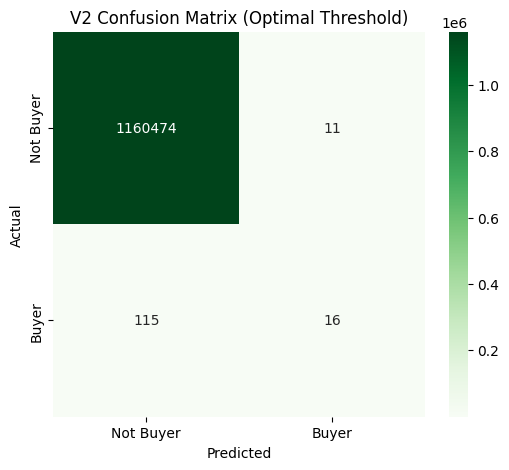

In [ ]:
# STEP 6: EVALUATE MODEL WITH OPTIMAL THRESHOLD
# ---------------------------------------------
print("\nSTEP 6: Evaluating Model and Finding Optimal Threshold...")
y_pred_proba = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold found at: {optimal_threshold:.4f}")

y_pred_binary_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# --- V2 Model Performance ---
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_binary_optimal)
new_precision = precision_score(y_test, y_pred_binary_optimal)
new_recall = recall_score(y_test, y_pred_binary_optimal)

print("\n--- V2 MODEL PERFORMANCE METRICS ---")
print(f"ROC AUC Score: {auc:.4f}")
print(f"F1 Score (at optimal threshold): {f1:.4f}")
print(f"Precision (at optimal threshold): {new_precision:.4f}")
print(f"Recall (at optimal threshold): {new_recall:.4f}")

# Visualize the new confusion matrix
cm = confusion_matrix(y_test, y_pred_binary_optimal)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Buyer', 'Buyer'], yticklabels=['Not Buyer', 'Buyer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('V2 Confusion Matrix (Optimal Threshold)')
plt.show()

In [ ]:
# STEP 7: SAVE FINAL V2 ARTIFACTS
# -------------------------------
print("\nSTEP 7: Saving V2 Model and Feature List...")
joblib.dump(model, 'propensity_to_buy_model_v2.pkl')

features_list = X_train.columns.tolist()
with open('features_v2.json', 'w') as f:
    json.dump(features_list, f)

print("\n✅ V2 artifacts ('propensity_to_buy_model_v2.pkl' and 'features_v2.json') saved successfully!")
print("You can now download these files from the file browser on the left side of Colab.")


STEP 7: Saving V2 Model and Feature List...

✅ V2 artifacts ('propensity_to_buy_model_v2.pkl' and 'features_v2.json') saved successfully!
You can now download these files from the file browser on the left side of Colab.
